# Ordered MNIST digits examample from Kostic et al. NeurIPS 2022

## Data pipeline

In [3]:
%load_ext autoreload
#Configs
import ml_confs as mlcfg
configs = mlcfg.from_file('configs.yaml')

In [2]:
#Data pipeline
from datasets import load_dataset, interleave_datasets, DatasetDict
MNIST = load_dataset('mnist', keep_in_memory=True)
digit_ds = []
for i in range(configs.classes):
    digit_ds.append(MNIST.filter(lambda example: example['label'] == i, keep_in_memory=True, num_proc=8))
ordered_MNIST = DatasetDict()
#Order the digits in the dataset and select only a subset of the data
for split in ['train', 'test']:
    ordered_MNIST[split] = interleave_datasets([ds[split] for ds in digit_ds], split=split).select(range(configs[f'{split}_samples']))
_tmp_ds = ordered_MNIST['train'].train_test_split(test_size=configs.val_ratio, shuffle=False)
ordered_MNIST['train'] = _tmp_ds['train']
ordered_MNIST['validation'] = _tmp_ds['test']

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

train(800) example: [0, 1, 2, 3, 4]
test(1001) example: [0, 1, 2, 3, 4]
validation(201) example: [0, 1, 2, 3, 4]


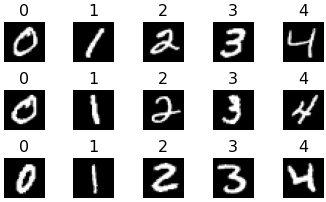

In [4]:
#Checking the data
import matplotlib.pyplot as plt
import scienceplots #Nicer styles
plt.style.use(['science','notebook', 'retro'])
plt.rcParams['figure.dpi'] = 72

fig, ax = plt.subplots(3, configs.classes, figsize=(configs.classes, 3))

for j, split in enumerate(['train', 'test', 'validation']):
    print(f'{split}({len(ordered_MNIST[split])}) example: {ordered_MNIST[split]["label"][:configs.classes]}')
    for i in range(configs.classes):
        data = ordered_MNIST['train'][configs.classes*j + i]
        ax[j, i].imshow(data['image'], cmap='gray')
        ax[j, i].set_title(data['label'])
        ax[j, i].axis('off')
fig.tight_layout()

In [5]:
#Cast to float32 and normalize to [0, 1]
ordered_MNIST.set_format(type='torch', columns=['image', 'label'])
ordered_MNIST = ordered_MNIST.map(lambda example: {'image': example['image']/255.0, 'label': example['label']}, batched=True, keep_in_memory=True, num_proc=2)
#Creating a copy of the dataset in numpy format
np_ordered_MNIST = ordered_MNIST.with_format(type='numpy', columns=['image', 'label'])

Map (num_proc=2):   0%|          | 0/800 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1001 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/201 [00:00<?, ? examples/s]

## Setting up a validation scheme
The validation of each model will be performed as follows: starting from a test image of the digit $c$, we will predict the next image by calling `model.predict`. The prediction should be an MNIST-alike image of the digit $c+1$ (modulo `configs.classes`). We will feed this prediction to a very strong MNIST classifier, and evaluate how its accuracy degrades over time.

### Defining the _oracle_ classifier

In [6]:
import torch.nn as nn
import torch

#Setting up the architecture
class CNNEncoder(nn.Module):
    def __init__(self, num_classes):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output num_classes classes
        self.out = nn.Sequential(
            nn.Linear(32 * 7 * 7, num_classes)
        )  
        torch.nn.init.orthogonal_(self.out[0].weight)      
    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(1) # add channel dimension if needed
            
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

We wrap the oracle classifier around a `kooplearn.abc.TrainableFeatureMap`. This will allow us to easily replicate the setting of Kostic et al. 2022, and it is pedagogical to show how `kooplearn` can be extended.

In [7]:
import logging
import os
import lightning
import numpy as np
from pathlib import Path
import pickle
from kooplearn.abc import TrainableFeatureMap
from typing import Optional

#Following kooplearn implementations, we define a Pytorch Lightning module
class ClassifierModule(lightning.LightningModule):
    def __init__(self, num_classes: int, learning_rate: float):
        super().__init__()
        self.num_classes = num_classes
        self.encoder = CNNEncoder(num_classes=num_classes)
        self.learning_rate = learning_rate
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        output = self.encoder(images)               
        loss = self.loss_fn(output, labels)
        with torch.no_grad():
            pred_labels = output.argmax(dim=1)
            accuracy = (pred_labels == labels).float().mean()
        return {'loss': loss, 'accuracy': accuracy}
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        output = self.encoder(images)  
        pred_labels = output.argmax(dim=1)
        accuracy = (pred_labels == labels).float().mean() # Scalar
        return {'accuracy': accuracy}
    
class ClassifierFeatureMap(TrainableFeatureMap):
    def __init__(
                self, 
                num_classes: int,
                learning_rate: float,
                trainer_kwargs: dict,
                seed: Optional[int] = None  
                ):
        #Set rng seed
        lightning.seed_everything(seed)
        self.seed = seed
        self._lightning_module = ClassifierModule(num_classes, learning_rate)
        
        #Init trainer
        self.trainer = lightning.Trainer(**trainer_kwargs)
        
        self._storage = {
            'num_classes': num_classes,
            'learning_rate': learning_rate,
            'trainer_kwargs': trainer_kwargs,
            'seed': seed
        }
        self._trainer_kwargs = trainer_kwargs
        self._is_fitted = False
        
    @property
    def is_fitted(self) -> bool:
        return self._is_fitted
    
    @property
    def lookback_len(self) -> int:
        return 1 #Hardcoding it here, as we are not using lookback windows
    
    def save(self, path: os.PathLike):
        path = Path(path)
        path.mkdir(parents=True, exist_ok=True)
        ckpt = path / 'weights.ckpt'
        params = path / 'params.pkl'
        self.trainer.save_checkpoint(str(ckpt))
        self._storage['is_fitted'] = self._is_fitted
        with open(params, 'wb') as f:
            pickle.dump(self._storage, f)

    @classmethod
    def load(cls, path: os.PathLike):
        with open(Path(path) / 'params.pkl', 'rb') as f:
            storage = pickle.load(f)
        _is_fitted = storage.pop('is_fitted')
        feature_map = cls(**storage)
        feature_map._is_fitted = _is_fitted
        ckpt = Path(path) / 'weights.ckpt'
        feature_map._lightning_module = ClassifierModule.load_from_checkpoint(str(ckpt))
        return feature_map

    def fit(self, **trainer_fit_kwargs: dict):
        if 'model' in trainer_fit_kwargs:
            logging.warn("The 'model' keyword should not be specified in trainer_fit_kwargs. The model is automatically set to the DPNet feature map, and the provided model is ignored.")
            trainer_fit_kwargs = trainer_fit_kwargs.copy()
            del trainer_fit_kwargs['model']
        self.trainer.fit(model=self._lightning_module, **trainer_fit_kwargs)
        self._is_fitted = True

    def __call__(self, X: np.ndarray) -> np.ndarray:
        X = torch.from_numpy(X).float()
        X.to(self._lightning_module.device)
        self._lightning_module.eval()
        with torch.no_grad():
            embedded_X = self._lightning_module.encoder(X)
            embedded_X = embedded_X.detach().numpy()
        return embedded_X

Let's train `ClassifierFeatureMap` on our `ordered_MNIST` dataset

In [8]:
from torch.utils.data import DataLoader
train_dl = DataLoader(ordered_MNIST['train'], batch_size=configs.batch_size, shuffle=True)
val_dl = DataLoader(ordered_MNIST['validation'], batch_size=len(ordered_MNIST['validation']), shuffle=False)

#Metrics Logging
from lightning.pytorch.callbacks import Callback
class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_acc = []
        self.train_steps = []
        self.val_acc = []
        self.val_steps = []

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # Get the metrics from the last training step
        self.train_acc.append(outputs['accuracy'].item())
        self.train_steps.append(trainer.global_step)
    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx = 0):
        # Get the metrics from the last validation step
        self.val_acc.append(outputs['accuracy'].item())
        self.val_steps.append(trainer.global_step)
        
metrics = MetricsCallback()
trainer_kwargs = {
    'accelerator': 'cpu',
    'max_epochs': 20,
    'log_every_n_steps': None,
    'callbacks': [metrics]
}

oracle = ClassifierFeatureMap(
    configs.classes,
    1e-2,
    trainer_kwargs, 
    seed=configs.rng_seed
)

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*") #Ignore warnings about num_workers

oracle.fit(train_dataloaders=train_dl, val_dataloaders=val_dl)

Global seed set to 0
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/pietronovelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name    | Type             | Params
---------------------------------------------
0 | encoder | CNNEncoder       | 21.1 K
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
21.1 K    Trainable params
0         Non-trainable params
21.1 K    Total params
0.084     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/pietronovelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


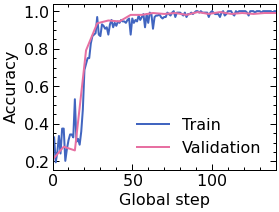

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(metrics.train_steps, metrics.train_acc, label='Train')
ax.plot(metrics.val_steps, metrics.val_acc, label='Validation')
ax.set_xlabel('Global step')
ax.set_ylabel('Accuracy')
ax.legend(frameon=False)
ax.margins(x=0)

In [10]:
import kooplearn.abc
def evaluate_model(model: kooplearn.abc.BaseModel, test_data):
    assert model.is_fitted
    test_labels = test_data['label']
    test_images = test_data['image']
    test_images = np.expand_dims(test_images, 1)
    report = {
        'accuracy': [],
        'label': [],
        'image': [],
        'times': []
    }
    for t in range(1, configs.eval_up_to_t + 1):
        pred = model.predict(test_images, t=t).reshape(-1, 28 ,28)
        pred_labels = oracle(pred)
        pred_labels = pred_labels.argmax(axis=1)
        accuracy = (pred_labels == (test_labels + t)%configs.classes ).mean()
        report['accuracy'].append(accuracy)
        report['image'].append(pred)
        report['label'].append(pred_labels)
        report['times'].append(t)
    return report

## Fitting some models with `kooplearn`

In [11]:
from kooplearn.models import DMD, KernelDMD, DeepEDMD
from kooplearn._src.context_window_utils import trajectory_to_contexts

context_len = 2
train_data = trajectory_to_contexts(np_ordered_MNIST['train']['image'], context_len)
val_data = trajectory_to_contexts(np_ordered_MNIST['validation']['image'], context_len)
transfer_operator_models = {}

#### Dynamic Mode Decomposition (DMD)

In [12]:
dmd_model = DMD(reduced_rank = configs.reduced_rank, rank=configs.classes).fit(train_data)
print(f"Train risk: {dmd_model.risk():.3f}\nValidation risk: {dmd_model.risk(val_data):.3f}")
transfer_operator_models['DMD'] = dmd_model

Train risk: 51.510
Validation risk: 49.081


#### Classifier features (as in Sec. 6 of Kostic et al. 2022)

In [13]:
classifier_model = DeepEDMD(oracle, reduced_rank=False, rank=configs.classes).fit(train_data)
print(f"Train risk: {classifier_model.risk():.3f}\nValidation risk: {classifier_model.risk(val_data):.3f}")
transfer_operator_models['Classifier-DeepEDMD'] = classifier_model

Train risk: 108.258
Validation risk: 107.965


/var/folders/hv/61b9_7692vs_qnbhp7fxkmfh0000gn/T/ipykernel_99085/2461557194.py:102: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  X = torch.from_numpy(X).float()


### Gaussian KernelDMD

Median heuristic: 14.840


Lengthscale search:   0%|          | 0/51 [00:00<?, ?it/s]

Best lengthscale: 11.664


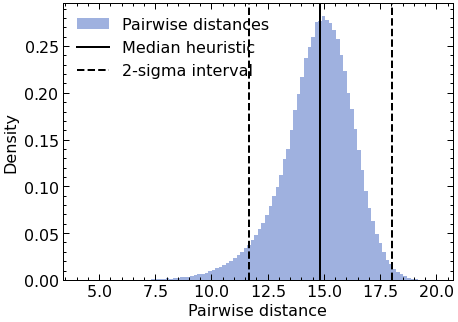

In [14]:
from sklearn.gaussian_process.kernels import RBF
from tqdm.notebook import tqdm
#Optimization of the kernel lengthscale:

#The median heuristic is a good starting point
from scipy.spatial.distance import pdist
pairwise_distances = pdist(train_data.reshape(train_data.shape[0], -1))
ls0 = np.median(pairwise_distances)
print(f"Median heuristic: {ls0:.3f}")
#Average deviation from the median
d_ls = np.sqrt(np.mean((pairwise_distances - ls0)**2))
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(pairwise_distances, bins=100, density=True, label='Pairwise distances', alpha = 0.5)
ax.axvline(ls0, color='k', label='Median heuristic')
ax.axvline(ls0 + 2*d_ls, color='k', linestyle='--', label='2-sigma interval')
ax.axvline(ls0 - 2*d_ls, color='k', linestyle='--')
ax.set_xlabel('Pairwise distance')
ax.set_ylabel('Density')
ax.legend()
length_scales = np.linspace(ls0 - 2*d_ls, ls0 + 2*d_ls, 51) #Search in a 2-sigma interval around the median heuristic
val_accuracies = []
for ls in tqdm(length_scales, desc='Lengthscale search'):
    _kernel_model = KernelDMD(kernel=RBF(ls), reduced_rank = configs.reduced_rank, rank=configs.classes).fit(train_data)
    acc = evaluate_model(_kernel_model, np_ordered_MNIST['validation'])['accuracy']
    val_accuracies.append(np.mean(acc))
best_ls = length_scales[np.argmax(val_accuracies)]
print(f"Best lengthscale: {best_ls:.3f}")

In [15]:
kernel_model = KernelDMD(kernel=RBF(best_ls), reduced_rank = configs.reduced_rank, rank=configs.classes, svd_solver='arnoldi').fit(train_data)
print(f"Train risk: {kernel_model.risk():.3f}\nValidation risk: {kernel_model.risk(val_data):.3f}")
transfer_operator_models['RBF-KernelDMD'] = kernel_model

Train risk: 0.292
Validation risk: 0.284


### DPNets

In [39]:
#Preparing data loaders
from torch.utils.data import Dataset

class ContextWindowDataset(Dataset):
    def __init__(self, contexts):
        self.contexts = contexts
    def __len__(self):
        return len(self.contexts)
    def __getitem__(self, idx):
        return self.contexts[idx]

train_ds = ContextWindowDataset(torch.from_numpy(train_data))
val_ds = ContextWindowDataset(torch.from_numpy(val_data))

train_dl = DataLoader(train_ds, batch_size=configs.batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=False)

In [42]:
%autoreload 2
from kooplearn.models.feature_maps import DPNet

metric_reg = 0.0
lr = 1e-3
epoch_budget = 200

trainer_kwargs = {
        'accelerator': 'cpu',
        'max_epochs': epoch_budget,
        'log_every_n_steps': None
    }

feature_map = DPNet(
    CNNEncoder,
    {'num_classes': configs.classes},
    metric_reg,
    torch.optim.Adam,
    {'lr': lr},
    trainer_kwargs,
    use_relaxed_loss=True,
    metric_reg_type='log_fro'
)


feature_map.fit(
    train_dataloaders=train_dl,     
)

Global seed set to 0
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type       | Params
-----------------------------------------------
0 | encoder_init    | CNNEncoder | 21.1 K
1 | encoder_evolved | CNNEncoder | 21.1 K
-----------------------------------------------
42.2 K    Trainable params
0         Non-trainable params
42.2 K    Total params
0.169     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [45]:
dpnet_model = DeepEDMD(feature_map, reduced_rank=False, rank=configs.classes).fit(train_data)
print(f"Train risk: {dpnet_model.risk():.3f}\nValidation risk: {dpnet_model.risk(val_data):.3f}")
transfer_operator_models['DPNet'] = dpnet_model

Train risk: 0.280
Validation risk: 0.292


## Examining the results

In [46]:
report = {}
for model_name, model in transfer_operator_models.items():
    print(f"Evaluating {model_name}")
    report[model_name] = evaluate_model(model, np_ordered_MNIST['test'])

Evaluating DMD
Evaluating Classifier-DeepEDMD
Evaluating RBF-KernelDMD
Evaluating DPNet


Text(0.5, 1.0, 'Classifier accuracy')

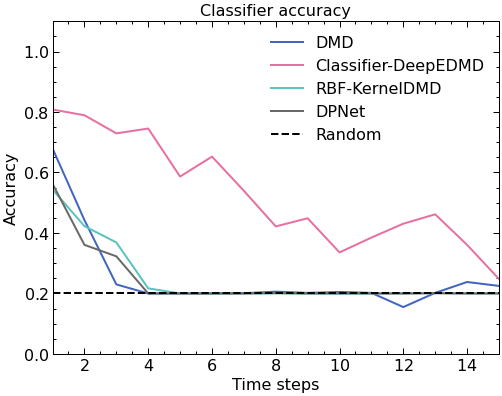

In [47]:
fig, ax = plt.subplots()
for model_name in report.keys():
    t = report[model_name]['times']
    acc = report[model_name]['accuracy']
    ax.plot(t, acc, label=model_name)

ax.axhline(1/configs.classes, color='black', linestyle='--', label='Random')

ax.legend(frameon=False)
ax.margins(x=0)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Time steps')
ax.set_ylabel('Accuracy')
ax.set_title('Classifier accuracy')

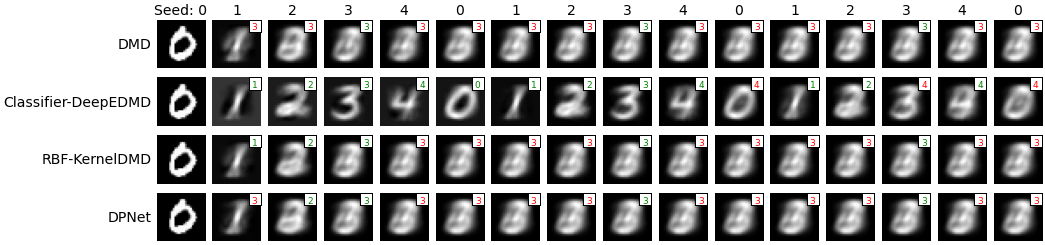

In [48]:
n_models = len(report.keys())
num_cols = configs.eval_up_to_t + 1
fig, axes = plt.subplots(n_models, num_cols, figsize=(num_cols, n_models), sharex=True, sharey=True)

test_seed_idx = 0
# Remove margins between columns
plt.subplots_adjust(wspace=0)

for model_idx, model_name in enumerate(report.keys()):
    ax = axes[model_idx, 0]
    ax.imshow(np_ordered_MNIST['test']['image'][test_seed_idx], cmap='gray')
    # Remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    model_eval = report[model_name]

    for t_idx in range(num_cols - 1):
        pred_label = model_eval['label'][t_idx][test_seed_idx]
        true_label = (np_ordered_MNIST['test']['label'][test_seed_idx] + model_eval['times'][t_idx])%configs.classes
        img = model_eval['image'][t_idx][test_seed_idx]
        
        # Set subplot for the current class
        ax = axes[model_idx, t_idx + 1]
        
        # Plot the MNIST image
        ax.imshow(img, cmap='gray')
        
        # Remove axes and ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

        # Add a white background for the subplot
        ax.set_facecolor('white')
        
        # Add an inset for the predicted label in the upper right corner
        if pred_label == true_label:
            color = 'green'
        else:
            color = 'red'
        inset_ax = ax.inset_axes([0.75, 0.75, 0.25, 0.25])
        inset_ax.set_xlim(0, 1)
        inset_ax.set_ylim(0, 1)
        inset_ax.text(0.5, 0.4, f"{pred_label}" , color=color, fontsize=9, ha='center', va='center')
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])
        #inset_ax.axis('off')
        inset_ax.set_facecolor('white')
        

# Display the model names on the left of each row
for model_idx, model_name in enumerate(report.keys()):
    axes[model_idx, 0].text(-0.1, 0.5, model_name, fontsize=14, ha='right', va='center', transform=axes[model_idx, 0].transAxes)

for class_idx in range(num_cols):
    title = (np_ordered_MNIST['test']['label'][test_seed_idx] + class_idx)%configs.classes
    if class_idx == 0:
        axes[0, class_idx].set_title(f"Seed: {title}", fontsize=14)
    else:
        axes[0, class_idx].set_title(f"{title}", fontsize=14)

plt.show()